In [1]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['font.size'] = 15
data = """AGR1	   [1] Corn final plant population
AGR2	[2] Soybean final plant population
AGR3	   [3] Mid-season canopy N sensing
AGR4	   [4] Corn vegetative biomass at R6 (dry) 
AGR32	[32] Corn cob biomass at R6 (dry)
AGR33	[33] Corn grain biomass at R6 (dry)
AGR5	[5] Soybean vegetative biomass at R8 (stems and pods only; no leaves)
AGR34	[34] Soybean grain biomass at R8 (dry)
AGR6	[6] Cover crop (rye) biomass in late fall (no significant weeds)
AGR37	[37] Cover crop (rye) and weedy biomass in late fall
AGR38	[38] Weedy biomass (only) in late fall
AGR7	[7] Cover crop (rye) biomass at termination (spring) (no significant weeds)
AGR39	[39] Cover crop (rye) and weedy biomass at termination (spring)
AGR40	[40] Weedy biomass (only) at termination (spring)
AGR8	   [8] Wheat plant biomass at maturity 
AGR9	   [9] Corn vegetative biomass total carbon at R6
AGR10	   [10] Corn vegetative biomass total nitrogen at R6 
AGR11	[11] Soybean vegetative biomass total carbon at R8
AGR12	[12] Soybean vegetative biomass total nitrogen at R8
AGR13	   [13] Rye biomass total carbon at fall
AGR14	   [14] Rye biomass total nitrogen at fall
AGR15	   [15] Rye biomass total carbon at spring
AGR16	   [16] Rye biomass total nitrogen at spring
AGR41	[41] Red clover or mixed cover crop biomass
AGR42	[42] Red clover or mixed cover crop total nitrogen
AGR43	[43] Red clover or mixed cover crop total carbon
AGR17	   [17] Corn grain yield at 15.5% MB
AGR18	   [18] Corn grain moisture
AGR19	   [19] Soybean grain yield at 13.0% MB
AGR20	   [20] Soybean grain moisture
AGR21	   [21] Wheat grain yield at 13.5% MB
AGR22	   [22] Wheat grain moisture
AGR23	   [23] Corn grain total carbon at R6
AGR24	   [24] Corn cob total carbon at R6
AGR25	   [25] Corn grain total nitrogen at R6
AGR26	   [26] Corn cob total nitrogen at R6
AGR27	   [27] Soybean grain total carbon at R8
AGR28	   [28] Soybean grain total nitrogen at R8
AGR29	   [29] Wheat grain total carbon at maturity
AGR30	   [30] Wheat grain total nitrogen at maturity
AGR31	   [31] Corn stalk nitrate samples"""
varlookup = {}
for line in data.split("\n"):
    tokens = line.split()
    varlookup[ tokens[0] ] = " ".join(tokens[1:])

In [15]:
import psycopg2
import pandas as pd
import numpy as np
pgconn = psycopg2.connect(database='sustainablecorn', host='iemdb', user='nobody')
cursor = pgconn.cursor()
pd.set_printoptions(max_rows=400, max_columns=10)
pd.set_option('display.precision',2)
cursor.execute("""
 SELECT site, a.plotid, varname, value, year, p.rotation, p.tillage from agronomic_data a JOIN plotids p 
 ON (p.uniqueid = a.site and p.plotid = a.plotid)
 WHERE value ~* '[0-9\.]' and value != '.' and value !~* '<'
""")
rows = []
for row in cursor:
    rows.append( dict(siteid=row[0], plotid=row[1], varname=row[2], 
                      val=float(row[3].replace('%','').replace('..','.')),
                      year=row[4], rotation=row[5], tillage=row[6]) )
    
df = pd.DataFrame(rows)
print 'Loaded %s rows from the database!' % (len(df),)

Loaded 9949 rows from the database!


In [16]:
def myconv(v):
    if v['rotation'] in ['ROT36'] and v['year'] in [2011,2013,2015]:
        return 'CC Before Corn'
    if v['rotation'] in ['ROT4'] and v['year'] in [2011,2013,2015]:
        return 'Before Corn'
    if v['rotation'] in ['ROT37'] and v['year'] in [2012,2014]:
        return 'CC Before Corn'
    if v['rotation'] in ['ROT5'] and v['year'] in [2012,2014]:
        return 'Before Corn'
    if v['rotation'] in ['ROT4'] and v['year'] in [2012,2014]:
        return 'Before Soy'
    if v['rotation'] in ['ROT36'] and v['year'] in [2012,2014]:
        return 'CC Before Soy'
    if v['rotation'] in ['ROT37'] and v['year'] in [2011,2013,2015]:
        return 'CC Before Soy'
    if v['rotation'] in ['ROT5'] and v['year'] in [2011,2013,2015]:
        return 'Before Soy'
    
df['label'] = df.apply(myconv, raw=True, axis=1)

In [53]:
df.rotation.unique()

array([ROT1, ROT38, ROT4, ROT36, ROT37, ROT5, ROT2, ROT39, ROT41, ROT7,
       ROT6, ROT8, ROT56, ROT12, ROT54, ROT55, ROT17, ROT16, ROT15, ROT14,
       ROT13], dtype=object)

In [7]:
df.varname.unique()

array([AGR1, AGR3, AGR4, AGR6, AGR7, AGR17, AGR18, AGR32, AGR33, AGR9,
       AGR10, AGR19, AGR20, AGR24, AGR26, AGR2, AGR16, AGR15, AGR23, AGR25,
       AGR27, AGR28, AGR31, AGR34, AGR21, AGR22, AGR41, AGR42, AGR43, AGR5,
       AGR11, AGR12, AGR14, AGR39, AGR37, AGR38, AGR13, AGR8], dtype=object)

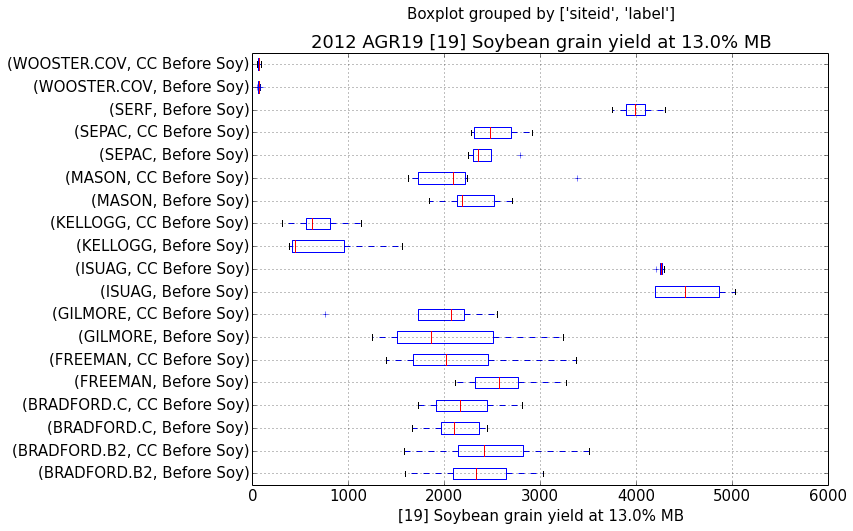

In [14]:
v = "AGR19"
ax = df[(df.varname==v)&(df.year==2012)&
        ((df.rotation=='ROT36')|(df.rotation=='ROT37')|(df.rotation=='ROT4')|(df.rotation=='ROT5'))
        ].boxplot(column='val', by=['siteid', 'label'], vert=False)
ax.set_title("2012 %s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)


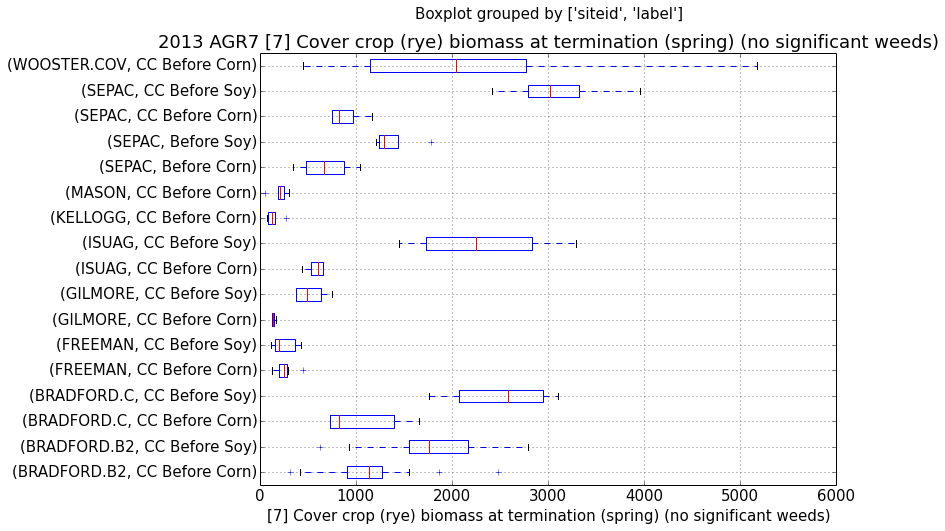

In [18]:
v = "AGR7"
ax = df[(df.varname==v)&(df.year==2013)&
        ((df.rotation=='ROT36')|(df.rotation=='ROT37')|(df.rotation=='ROT4')|(df.rotation=='ROT5'))
        ].boxplot(column='val', by=['siteid', 'label'], vert=False)
ax.set_title("2013 %s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)

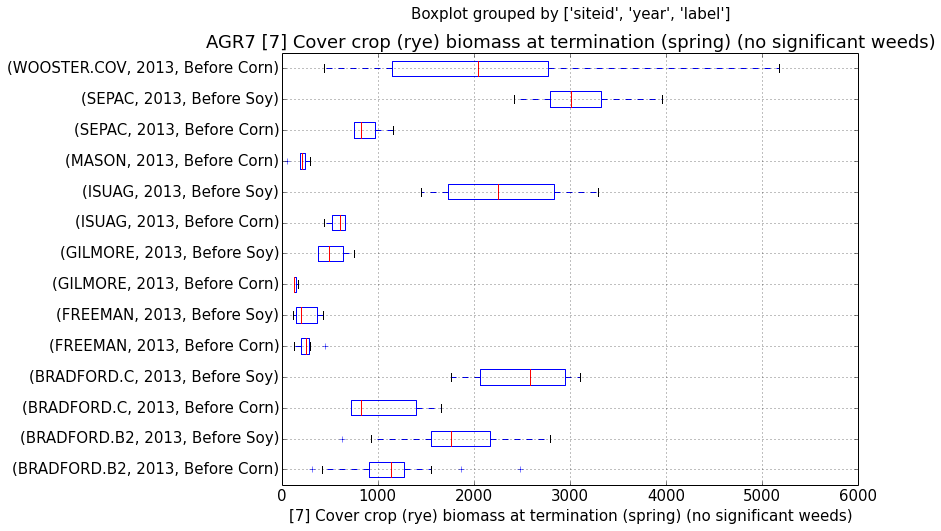

In [130]:
v = "AGR7"
ax = df[(df.varname==v)&
        (df.year==2013)&((df.rotation=='ROT36')|(df.rotation=='ROT37'))
        ].boxplot(column='val', by=['siteid', 'year', 'label'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)

In [136]:
v = "AGR7"
ax = df[(df.varname==v)
        ].boxplot(column='val', by=['sitev = "AGR7"
ax = df[(df.varname==v)&(df.rotation=='ROT37')
        ].boxplot(column='val', by=['siteid', 'year', 'rotation'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)

SyntaxError: EOL while scanning string literal (<ipython-input-136-c473e9475cc8>, line 3)

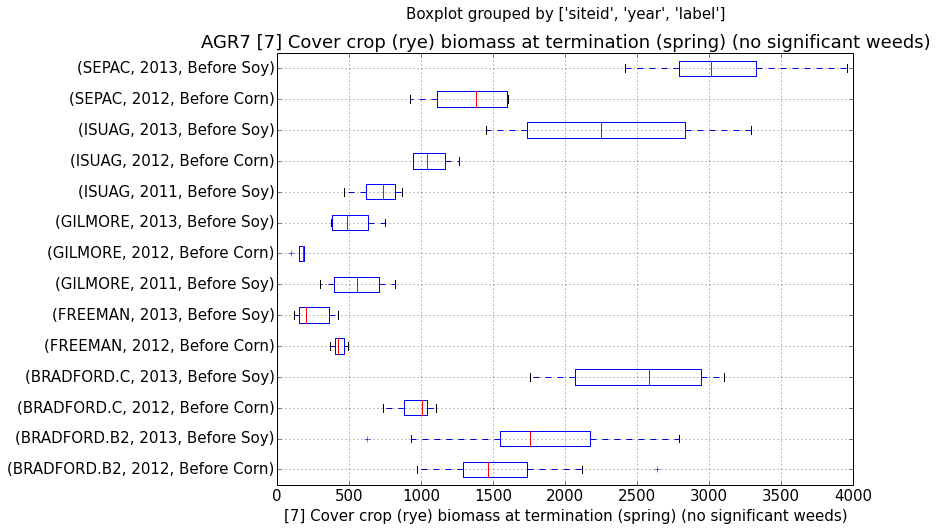

In [137]:
v = "AGR7"
ax = df[(df.varname==v)&(df.rotation=='ROT37')
        ].boxplot(column='val', by=['siteid', 'year', 'label'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)

In [ ]:
v = "AGR7"
ax = df[(df.varname==v)
        ].boxplot(column='val', by=['siteid', 'year', 'rotation'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
#ax.set_xlim(0,6000)

(0, 6000)

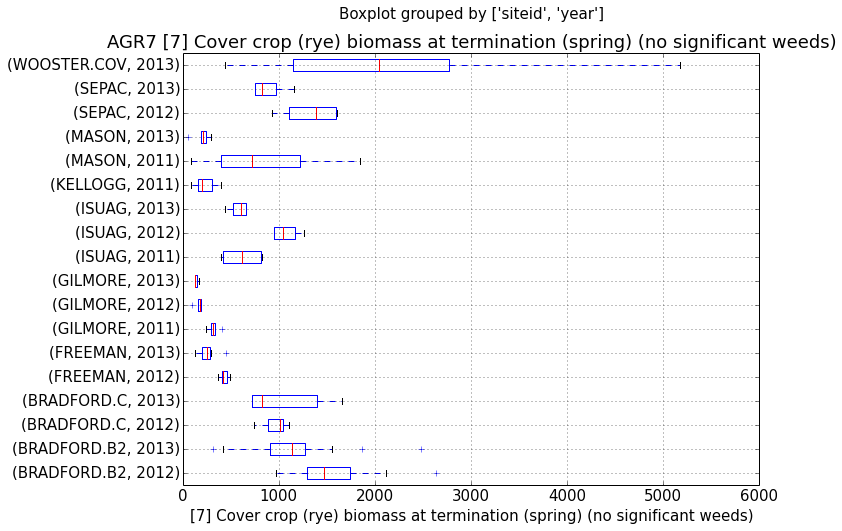

In [89]:
v = "AGR7"
ax = df[(df.varname==v)&
        (((df.year==2013)&(df.rotation=='ROT36'))|
         ((df.year==2011)&(df.rotation=='ROT36'))|
         ((df.year==2012)&(df.rotation=='ROT37')))
        ].boxplot(column='val', by=['siteid', 'year'], vert=False)
ax.set_title("%s %s" % (v, varlookup[v]))
ax.set_xlabel(varlookup[v])
ax.set_xlim(0,6000)

In [86]:
v = "AGR7"
print 'Showing %s %s' % (v, varlookup[v])
df[(df.varname==v)&
        (((df.year==2013)&(df.rotation=='ROT36'))|
         ((df.year==2011)&(df.rotation=='ROT36'))|
         ((df.year==2012)&(df.rotation=='ROT37')))
    ].pivot_table(rows=['siteid'], cols=['year'], aggfunc=np.average)

Showing AGR7 [7] Cover crop (rye) biomass at termination (spring) (no significant weeds)


val                
year          2011    2012    2013
siteid                            
BRADFORD.B2    NaN  1499.8  1117.3
BRADFORD.C     NaN   957.1  1050.6
FREEMAN        NaN   429.5   258.0
GILMORE      316.8   161.9   136.5
ISUAG        614.0  1071.2   576.5
KELLOGG      226.7     NaN     NaN
MASON        840.0     NaN   200.8
SEPAC          NaN  1320.8   889.0
WOOSTER.COV    NaN     NaN  2146.0

In [85]:
df.groupby('varname')["val"].describe()

varname       
AGR1     count       921.0
         mean      67556.3
         std       13967.6
         min        6175.0
         25%       61139.0
         50%       68900.0
         75%       74772.0
         max      250261.0
AGR10    count       379.0
         mean         38.7
         std          47.2
         min           0.2
         25%           7.6
         50%          29.8
         75%          50.9
         max         293.1
AGR11    count        39.0
         mean       2787.6
         std        1168.9
         min        1539.2
         25%        2225.2
         50%        2525.4
         75%        3717.4
         max        5907.7
AGR12    count        27.0
         mean         37.8
         std           8.4
         min          26.3
         25%          26.3
         50%          42.8
         75%          44.5
         max          44.5
AGR13    count         8.0
         mean        203.9
         std          36.6
         min         164.0
         25% 